In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINConv
from torch_geometric.utils import degree
import random
import numpy as np
import copy
import gc
from torch_geometric.loader import DataLoader
from torch_geometric.nn import JumpingKnowledge, global_add_pool


# The specific imports for Graph Neural Networks
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv

# --- 1. RAAG DEFINITION ---
# Commutation Graph: Even nodes commute with the next odd node
RAAG_ADJ = np.zeros((2001, 2001))
for i in range(2000):
    if i % 2 == 0:
        RAAG_ADJ[i][i+1] = 1
        RAAG_ADJ[i+1][i] = 1

class RAAGWord:
    def __init__(self, letters, adj_matrix=RAAG_ADJ):
        self.adj_matrix = adj_matrix
        self.letters = self.reduce(letters)

    def reduce(self, lts):
        # SAFETY CAP: Prevent "Infinite Growth" memory explosion
        if len(lts) > 60: lts = lts[:60]
        
        res = []
        for l in lts:
            if not res:
                res.append(l)
                continue
            idx = len(res) - 1
            can_cancel = False
            while idx >= 0:
                if res[idx] == -l:
                    can_cancel = True
                    break
                if not self.adj_matrix[abs(l)][abs(res[idx])]:
                    break
                idx -= 1
            if can_cancel:
                res.pop(idx)
            else:
                res.append(l)
        return res

    def __mul__(self, other):
        return RAAGWord(self.letters + other.letters, self.adj_matrix)

    def inv(self):
        return RAAGWord([-l for l in reversed(self.letters)], self.adj_matrix)

# --- 2. ALGEBRAIC MOVES & FAN TOPOLOGY ---
def apply_nielsen_moves_fixed(subgroup_basis, num_moves=10):
    scrambled = list(subgroup_basis)
    rank = len(scrambled)
    for _ in range(num_moves):
        i, j = random.sample(range(rank), 2)
        op = random.choice(['mul', 'inv_mul'])
        if op == 'mul':
            scrambled[i] = (scrambled[i][0] * scrambled[j][0], scrambled[i][1] * scrambled[j][1])
        else:
            j_inv = (scrambled[j][0].inv(), scrambled[j][1].inv())
            scrambled[i] = (scrambled[i][0] * j_inv[0], scrambled[i][1] * j_inv[1])
    return scrambled

def subgroup_to_graph(subgroup):
    x, edge_index = [], []
    
    # 1. Create Hubs (Nodes 0-4)
    for i in range(5):
        x.append([float(501 + i)]) 
    
    curr_idx = 5
    for i, (w_a, w_b) in enumerate(subgroup):
        hub_idx = i
        full_word = w_a.letters + w_b.letters
        if not full_word: full_word = [0]
        for letter in full_word:
            x.append([float(letter)])
            edge_index.append([curr_idx, hub_idx])
            edge_index.append([hub_idx, curr_idx])
            curr_idx += 1
    
    x_tensor = torch.tensor(x, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    # --- ADD THESE LINES TO FIX THE ERROR ---
    # Calculate degree: how many edges are connected to each node
    deg = degree(edge_index_tensor[0], num_nodes=x_tensor.size(0))
    
    # Create node_type: 0 for Hubs (first 5), 1 for Letters
    node_type = torch.ones(x_tensor.size(0), dtype=torch.long)
    node_type[:5] = 0 
    
    return Data(
        x=x_tensor, 
        edge_index=edge_index_tensor, 
        degree=deg,          # Fixes the AttributeError
        node_type=node_type  # Needed for the Hub-pooling logic
    )

def subgroup_to_graph_old(subgroup):
    """FAN TOPOLOGY: Connects every letter directly to its hub."""
    x, edge_index = [], []
    for i in range(5): x.append([float(501 + i)]) # 5 Hubs
    
    curr_idx = 5
    for i, (w_a, w_b) in enumerate(subgroup):
        hub_idx = i
        full_word = w_a.letters + w_b.letters
        if not full_word: full_word = [0]
        for letter in full_word:
            x.append([float(letter)])
            edge_index.append([curr_idx, hub_idx])
            edge_index.append([hub_idx, curr_idx])
            curr_idx += 1
            
    return Data(x=torch.tensor(x, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous())


# --- 4. KERNEL-SAFE DATA GENERATION ---
def triplet_generator(batch_size, nielsen_moves):
    """LAZY GENERATOR: Never creates more than one batch at a time."""
    while True:
        triplets = []
        for _ in range(batch_size):
            shift = random.randint(-400, 400)
            base_sub = [(RAAGWord([shift + i]), RAAGWord([shift + i + 100])) for i in range(5)]
            
            anchor = apply_nielsen_moves_fixed(base_sub, num_moves=random.randint(1, 5))
            pos = apply_nielsen_moves_fixed(base_sub, num_moves=nielsen_moves)
            
            # Surgical Negative: Change one generator only
            neg = copy.deepcopy(anchor)
            idx = random.randint(0, 4)
            neg[idx] = (RAAGWord([random.randint(-1000, 1000)]), neg[idx][1])
            
            triplets.append((subgroup_to_graph(anchor), subgroup_to_graph(pos), subgroup_to_graph(neg)))
        
        yield (Batch.from_data_list([t[0] for t in triplets]),
               Batch.from_data_list([t[1] for t in triplets]),
               Batch.from_data_list([t[2] for t in triplets]))

def generate_triplets_hardened_v2(num_samples, nielsen_moves, surgical_prob=0.5):
    """
    Generates a large batch of triplets.
    surgical_prob: Probability of a 'Surgical' negative (hard) vs 'Alphabet' (easy).
    """
    triplets = []
    for _ in range(num_samples):
        # 1. Setup Base
        shift = random.randint(-600, 600)
        # Generators A and B are 100 apart in the alphabet
        base_sub = [(RAAGWord([shift + i]), RAAGWord([shift + i + 100])) for i in range(5)]

        # 2. Positive Pair (Anchor and Scrambled)
        # Anchor gets a light scramble (1-5 moves) so it's not "perfect"
        anchor_sub = apply_nielsen_moves_fixed(base_sub, num_moves=random.randint(1, 5))
        # Positive gets the full scramble
        pos_sub = apply_nielsen_moves_fixed(base_sub, num_moves=nielsen_moves)

        # 3. Negative Pair
        if random.random() < surgical_prob:
            # HARD NEGATIVE: Take the anchor and change one generator to a random letter
            neg_sub = copy.deepcopy(anchor_sub)
            idx = random.randint(0, 4)
            # Replace one generator in the pair with a random one
            neg_sub[idx] = (RAAGWord([random.randint(-1000, 1000)]), neg_sub[idx][1])
        else:
            # EASY NEGATIVE: Pick a completely different alphabet range
            # Ensure the new shift is far away from the original shift
            alt_shift = random.choice([s for s in range(-600, 600) if abs(s - shift) > 200])
            neg_base = [(RAAGWord([alt_shift + i]), RAAGWord([alt_shift + i + 100])) for i in range(5)]
            neg_sub = apply_nielsen_moves_fixed(neg_base, num_moves=random.randint(1, 5))

        triplets.append((
            subgroup_to_graph(anchor_sub),
            subgroup_to_graph(pos_sub),
            subgroup_to_graph(neg_sub)
        ))
    return triplets

def generate_triplets_v4(num_samples, nielsen_moves, hard_prob=0.8):
    """
    V4: Includes Algebraic Dependency Decoys.
    Forces the model to distinguish between a full-rank subgroup 
    and one where a generator is just a product of the others.
    """
    triplets = []
    for _ in range(num_samples):
        # 1. Setup Anchor
        shift = random.randint(-500, 500)
        base_sub = [(RAAGWord([shift + i]), RAAGWord([shift + i + 100])) for i in range(5)]
        
        anchor_sub = apply_nielsen_moves_fixed(base_sub, num_moves=random.randint(1, 5))
        pos_sub = apply_nielsen_moves_fixed(base_sub, num_moves=nielsen_moves)

        # 2. Select Negative Type
        dice = random.random()
        
        if dice < (hard_prob * 0.8):
            # TYPE A: ALGEBRAIC DEPENDENCY (The Hardest)
            # Replace Slot 4 with Slot 0 * Slot 1. Alphabet is identical, algebra is collapsed.
            neg_sub = copy.deepcopy(anchor_sub)
            i, j = random.sample(range(4), 2) # Pick two to combine
            idx_to_kill = 4                   # Replace the 5th
            
            # Create a product: g_new = g_i * g_j
            combined = (neg_sub[i][0] * neg_sub[j][0], neg_sub[i][1] * neg_sub[j][1])
            neg_sub[idx_to_kill] = combined
            
            # Scramble to hide the length of the product
            neg_sub = apply_nielsen_moves_fixed(neg_sub, num_moves=nielsen_moves)

        elif dice < hard_prob:
            # TYPE B: SURGICAL SUBSTITUTION
            # Replace one generator with a random one from a far-away alphabet
            neg_sub = copy.deepcopy(anchor_sub)
            idx = random.randint(0, 4)
            bad_shift = random.choice([s for s in range(-1000, 1000) if abs(s - shift) > 300])
            neg_sub[idx] = (RAAGWord([bad_shift]), RAAGWord([bad_shift + 50]))
            neg_sub = apply_nielsen_moves_fixed(neg_sub, num_moves=nielsen_moves)

        else:
            # TYPE C: EASY ALPHABET SHIFT
            alt_shift = random.choice([s for s in range(-600, 600) if abs(s - shift) > 200])
            neg_base = [(RAAGWord([alt_shift + i]), RAAGWord([alt_shift + i + 100])) for i in range(5)]
            neg_sub = apply_nielsen_moves_fixed(neg_base, num_moves=5)

        triplets.append((
            subgroup_to_graph(anchor_sub),
            subgroup_to_graph(pos_sub),
            subgroup_to_graph(neg_sub)
        ))
    return triplets

# --- REFINED MODEL FOR NUMERICAL REASONING ---
class UniversalHubGNN(nn.Module):
    def __init__(self, hidden=256): # Increased hidden size for 512 batch
        super().__init__()
        # Linear encoder treats node IDs as coordinates, not just labels
        self.node_encoder = nn.Linear(1, hidden) 
        self.lin_deg = nn.Linear(1, hidden)
        self.convs = nn.ModuleList([
            GINConv(nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden)))
            for _ in range(4) # Reduced layers to 4 to speed up 512-batch processing
        ])
        self.lns = nn.ModuleList([nn.LayerNorm(hidden) for _ in range(4)])
        self.fc = nn.Sequential(
            nn.Linear(5 * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 64)
        )

    def forward_one(self, data):
        # Normalize node values to help the Linear layer see the 'Alphabet'
        x = self.node_encoder(data.x / 1000.0) 
        
        row, _ = data.edge_index
        deg = torch.zeros((data.x.size(0), 1), device=data.x.device)
        deg.scatter_add_(0, row.unsqueeze(1), torch.ones((row.size(0), 1), device=data.x.device))
        x = x + self.lin_deg(deg)

        for conv, ln in zip(self.convs, self.lns):
            h = conv(x, data.edge_index)
            x = ln(F.relu(h) + x) # Removed Dropout to stabilize large batch loss

        # Pooling logic...
        num_graphs = data.num_graphs if hasattr(data, 'num_graphs') else 1
        hub_embeddings = []
        if hasattr(data, 'ptr') and data.ptr is not None:
            for i in range(num_graphs):
                start = data.ptr[i]
                hub_embeddings.append(x[start : start + 5].reshape(-1))
        else:
            hub_embeddings.append(x[:5].reshape(-1))

        return F.normalize(self.fc(torch.stack(hub_embeddings)), p=2, dim=1)


class WideHubGNN(nn.Module):
    def __init__(self, hidden_channels=512, out_emb=128, num_layers=5):
        super(WideHubGNN, self).__init__()
        
        # 1. Wide Input Encoding
        self.node_encoder = nn.Linear(1, hidden_channels)
        self.deg_encoder = nn.Linear(1, hidden_channels)
        
        # 2. GIN Layers with Residual Setup
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels * 2),
                nn.ReLU(),
                nn.Linear(hidden_channels * 2, hidden_channels),
                nn.BatchNorm1d(hidden_channels)
            )
            self.convs.append(GINConv(mlp))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # 3. Jumping Knowledge: Remembers "Clean" features from early layers
        self.jk = JumpingKnowledge(mode='cat', channels=hidden_channels, num_layers=num_layers)
        # Assuming: hidden_channels=512, num_layers=5
        jk_size = hidden_channels * num_layers # 512 * 5 = 2560
        total_hub_input = jk_size * 5          # 2560 * 5 = 12800
        
        self.fc = nn.Sequential(
            nn.Linear(total_hub_input, 1024),  # Changed from 2560 to 12800
            nn.ReLU(),
            nn.Linear(1024, out_emb)           # out_emb is your final 64 or 128
        )

    def forward_one(self, data):
        # data.x: [TotalNodes, 1]
        # data.edge_index: [2, TotalEdges]
        # data.batch: [TotalNodes] 
        # data.degree: [TotalNodes]
        # data.node_type: [TotalNodes] (0 for hubs, 1 for letters)
    
        x, edge_index = data.x, data.edge_index
        
        # 1. Input Encoding: Normalize node values and add structural degree signal
        # Shape: [TotalNodes, hidden_channels]
        deg = data.degree.view(-1, 1).float() / 100.0 
        x = self.node_encoder(x / 1000.0) + self.deg_encoder(deg)
        
        layer_outputs = []
        
        # 2. Message Passing with Residual Connections
        for conv, bn in zip(self.convs, self.batch_norms):
            identity = x # Save for skip connection
            h = conv(x, edge_index)
            x = bn(F.relu(h + identity)) # Residual Step
            layer_outputs.append(x) # Save state for Jumping Knowledge
            
        # 3. Jumping Knowledge: Concatenate all layer outputs
        # If hidden=512 and num_layers=5, x_jk shape: [TotalNodes, 2560]
        x_jk = self.jk(layer_outputs)
        
        # 4. Hub Extraction (The "Slot-Aware" part)
        # node_type == 0 marks our 5 Generators (Hubs)
        hub_mask = (data.node_type == 0)
        h_hubs = x_jk[hub_mask] 
        # Shape: [BatchSize * 5, 2560]
        
        # 5. Flattening for the Decision Head
        # We combine the 5 hubs into one long feature vector for the MLP
        # Shape: [BatchSize, 12800]
        h_hubs = h_hubs.view(-1, 5 * x_jk.size(-1))
        
        # 6. Final Projection & Normalization
        # Project 12800 -> 1024 -> out_emb (e.g., 128)
        out = self.fc(h_hubs)
        
        # Return L2-normalized embedding for Cosine Similarity
        return F.normalize(out, p=2, dim=1)
        
    def forward(self, anchor, positive, negative):
        # Triplet Forward Pass
        return self.forward_one(anchor), self.forward_one(positive), self.forward_one(negative)

def generate_triplets_v4(num_samples, nielsen_moves, hard_prob=0.8):
    triplets = []
    for _ in range(num_samples):
        shift = random.randint(-500, 500)
        base_sub = [(RAAGWord([shift + i]), RAAGWord([shift + i + 100])) for i in range(5)]
        anchor_sub = apply_nielsen_moves_fixed(base_sub, num_moves=random.randint(1, 5))
        pos_sub = apply_nielsen_moves_fixed(base_sub, num_moves=nielsen_moves)

        dice = random.random()
        if dice < (hard_prob * 0.8):
            neg_type = 0 # ALGEBRAIC
            neg_sub = copy.deepcopy(anchor_sub)
            i, j = random.sample(range(4), 2)
            neg_sub[4] = (neg_sub[i][0] * neg_sub[j][0], neg_sub[i][1] * neg_sub[j][1])
            neg_sub = apply_nielsen_moves_fixed(neg_sub, num_moves=nielsen_moves)
        elif dice < hard_prob:
            neg_type = 1 # SURGICAL
            neg_sub = copy.deepcopy(anchor_sub)
            idx = random.randint(0, 4)
            bad_shift = random.choice([s for s in range(-1000, 1000) if abs(s - shift) > 300])
            neg_sub[idx] = (RAAGWord([bad_shift]), RAAGWord([bad_shift + 50]))
            neg_sub = apply_nielsen_moves_fixed(neg_sub, num_moves=nielsen_moves)
        else:
            neg_type = 2 # ALPHABET
            alt_shift = random.choice([s for s in range(-600, 600) if abs(s - shift) > 200])
            neg_base = [(RAAGWord([alt_shift + i]), RAAGWord([alt_shift + i + 100])) for i in range(5)]
            neg_sub = apply_nielsen_moves_fixed(neg_base, num_moves=5)

        # Create graphs
        a_graph, p_graph, n_graph = subgroup_to_graph(anchor_sub), subgroup_to_graph(pos_sub), subgroup_to_graph(neg_sub)
        
        # Attach the label to the anchor so we can retrieve it in the batch
        a_graph.neg_type = torch.tensor([neg_type])
        
        triplets.append((a_graph, p_graph, n_graph))
    return triplets

class ResJumperGNN(nn.Module):
    def __init__(self, hidden_channels=256, out_emb=128, num_layers=4):
        super(ResJumperGNN, self).__init__()
        
        self.node_encoder = nn.Linear(1, hidden_channels)
        self.deg_encoder = nn.Linear(1, hidden_channels)
        
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for _ in range(num_layers):
            # GIN with a lighter MLP internal structure
            mlp = nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.BatchNorm1d(hidden_channels)
            )
            self.convs.append(GINConv(mlp))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        # Jumping Knowledge (JK) is great for RAAGs because it 
        # keeps the 'local' alphabet info available at the final layer.
        self.jk = JumpingKnowledge(mode='cat', channels=hidden_channels, num_layers=num_layers)
        
        # Calculation: 256 channels * 4 layers = 1024 features per node
        jk_size = hidden_channels * num_layers 
        
        # Instead of 12800 -> 1024, we do a more efficient 5120 -> 512
        self.fc = nn.Sequential(
            nn.Linear(jk_size * 5, 512), 
            nn.ReLU(),
            nn.Dropout(0.1), # Added a touch of dropout for regularization
            nn.Linear(512, out_emb)
        )

    def forward_one(self, data):
        x, edge_index = data.x, data.edge_index
        
        # 1. Input Encoding
        deg = data.degree.view(-1, 1).float() / 100.0 
        x = self.node_encoder(x / 1000.0) + self.deg_encoder(deg)
        
        layer_outputs = []
        
        # 2. Residual Message Passing
        for conv, bn in zip(self.convs, self.batch_norms):
            h = conv(x, edge_index)
            x = bn(F.relu(h + x)) # Skip connection
            layer_outputs.append(x)
            
        # 3. Jumping Knowledge
        x_jk = self.jk(layer_outputs)
        
        # 4. Slot-Aware Hub Extraction
        # We still look specifically at our 5 Hub nodes
        hub_mask = (data.node_type == 0)
        h_hubs = x_jk[hub_mask] 
        
        # Reshape to [Batch, 5 * JK_Size]
        # This keeps the 'order' of generators, which is vital for Algebraic checks
        h_hubs = h_hubs.view(-1, 5 * x_jk.size(-1))
        
        # 5. Output
        out = self.fc(h_hubs)
        return F.normalize(out, p=2, dim=1)

class TwinFlowGNN(nn.Module):
    def __init__(self, hidden=192, bottleneck=64, out_emb=64):
        super().__init__()
        # Use a more sensitive encoder for the node values
        self.node_enc = nn.Sequential(
            nn.Linear(1, hidden),
            nn.LeakyReLU(),
            nn.Linear(hidden, hidden)
        )
        
        # 3-Layer GIN: Deep enough for Nielsen moves, shallow enough to stay stable
        self.convs = nn.ModuleList([
            GINConv(nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden)))
            for _ in range(3)
        ])
        
        # The Bottleneck: Forces the model to discard alphabet noise
        self.bottleneck = nn.Linear(hidden * 5, bottleneck)
        
        self.head = nn.Sequential(
            nn.Linear(bottleneck, 128),
            nn.ReLU(),
            nn.Linear(128, out_emb)
        )

    def forward_one(self, data):
        # Normalize input rigorously: [min_id, max_id] -> [0, 1]
        x = self.node_enc(data.x / 1000.0)
        
        for conv in self.convs:
            x = F.relu(conv(x, data.edge_index) + x) # Residual help
            
        # Extract the 5 Hubs
        hub_mask = (data.node_type == 0)
        h_hubs = x[hub_mask].view(-1, 5 * x.size(-1))
        
        # Force through bottleneck
        b = F.relu(self.bottleneck(h_hubs))
        
        return F.normalize(self.head(b), p=2, dim=1)

@torch.no_grad()
def refresh_buffer_with_mining(model, current_buffer, device, target_size=65536, margin = 1.0):
    model.eval()
    all_losses = []
    
    # 1. Score the current buffer
    # Use a small loader to get through the buffer quickly
    temp_loader = DataLoader(current_buffer, batch_size=128, shuffle=False)
    
    for a, p, n in temp_loader:
        a, p, n = a.to(device), p.to(device), n.to(device)
        ea, ep, en = model.forward_one(a), model.forward_one(p), model.forward_one(n)
        
        # Calculate individual triplet losses (reduction='none' is key here)
        # It gives us one loss value per triplet instead of an average
        d_pos = torch.norm(ea - ep, p=2, dim=1)
        d_neg = torch.norm(ea - en, p=2, dim=1)
        # Margin = 1.0 (recommended to increase this)
        losses = torch.clamp(d_pos - d_neg + margin, min=0.0)
        all_losses.extend(losses.cpu().numpy())

    # 2. Identify the Hardest Triplets
    # Sort indices by loss (descending)
    indices = np.argsort(all_losses)[::-1]
    
    # Keep the top 50% (the ones the model is failing on)
    num_to_keep = int(target_size * 0.01)
    hard_indices = indices[:num_to_keep]
    new_buffer = [current_buffer[i] for i in hard_indices]
    
    # 3. Fill the rest with fresh "unseen" challenges
    print(f"Keeping {num_to_keep} hard samples. Generating fresh challenges...")
    fresh_samples = generate_triplets_v4(target_size - num_to_keep, nielsen_moves=15)
    new_buffer.extend(fresh_samples)
    
    return new_buffer

# --- SPEED-OPTIMIZED TRAINING ---

cases = ['Resjump', 'Wide', 'Twin', 'Universal']
device = torch.device('cuda')

for case in cases:

    if case == cases[0]:
        model = TwinFlowGNN(hidden = 256, out_emb = 128).to(device)
    elif case == cases[1]:
        model = UniversalHubGNN(hidden = 256, out_emb = 128).to(device)
    elif case == cases[2]:
        model = TwinFlowGNN().to(device)
    elif case == cases[3]:
        model = UniversalHubGNN().to(device)

    print(f'\nChosen model {case}')
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005) # Higher LR for large batch
    criterion = nn.TripletMarginLoss(margin=0.5)
    
    # Generate a large buffer ONCE to keep GPU saturated
    print("Generating Initial Buffer...")
    NUM_SAMPLES = 32768
    train_buffer = generate_triplets_v4(NUM_SAMPLES, nielsen_moves=15)
    
    
    # Training parameters
    MARGIN = 1.0 # Increased margin
    criterion = nn.TripletMarginLoss(margin=MARGIN)
    
    for epoch in range(1500):
        # --- HARD NEGATIVE MINING STEP ---
        if epoch > 0 and epoch % 5 == 0:
            print(f"--- Epoch {epoch}: Swapping 90% of samples")
            train_buffer = refresh_buffer_with_mining(model, train_buffer, device, target_size=NUM_SAMPLES, margin = 0.5)  
            #train_buffer = generate_triplets_v4(NUM_SAMPLES, nielsen_moves=15)
            
        model.train()
        total_loss = 0
        loader = DataLoader(train_buffer, batch_size=128, shuffle=True)
        
        for a, p, n in loader:
            optimizer.zero_grad(set_to_none=True)
            a, p, n = a.to(device), p.to(device), n.to(device)
            
            ea, ep, en = model.forward_one(a), model.forward_one(p), model.forward_one(n)
            
            loss = criterion(ea, ep, en)
            loss.backward()
            
            # Gradient Clipping: Prevents the model from 'exploding' when it hits 
            # a very difficult algebraic negative
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
            
        print(f"Epoch {epoch} | Average Loss: {total_loss/len(loader):.6f}")
        
    torch.save(model.state_dict(), f'model_{case}_{NUM_SAMPLES}_nightly_01.pth')

    
"""
for epoch in range(200):
    model.train()
    total_loss = 0
    
    # We rebuild the loader so it sees the refreshed buffer
    loader = DataLoader(train_buffer, batch_size=64, shuffle=True)
    
    for a, p, n in loader:
        optimizer.zero_grad(set_to_none=True)
        
        # 1. Move to device
        a, p, n = a.to(device), p.to(device), n.to(device)
        
        # 2. Forward pass
        ea = model.forward_one(a)
        ep = model.forward_one(p)
        en = model.forward_one(n)
        
        # 3. Compute loss
        loss = criterion(ea, ep, en)
        loss.backward()
        
        # 4. Step
        optimizer.step()
        total_loss += loss.item()

        # --- MEMORY GUARD ---
        # Explicitly delete the batch tensors to free GPU memory immediately
        del a, p, n, ea, ep, en, loss

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch} | Loss: {avg_loss}")    
    # --- BUFFER REFRESH LOGIC ---
    # Refreshing 20% of the buffer every 5 epochs
    if epoch % 5 == 0:
        print("Refreshing 50% of buffer...")
        num_to_refresh = int(len(train_buffer) * 0.5)
        
        # Generate new samples on CPU
        new_samples = generate_triplets_v4(num_to_refresh, nielsen_moves=15)
        
        # Randomly replace entries in the existing list
        indices = random.sample(range(len(train_buffer)), num_to_refresh)
        for idx, sample in zip(indices, new_samples):
            # Overwriting the index helps prevent memory fragmentation
            train_buffer[idx] = sample
            
        # Clear the sample list and force garbage collection
        del new_samples
        gc.collect() 
        torch.cuda.empty_cache() # Essential for WideHubGNN (512+ channels) """

torch.save(model.state_dict(), f'model_wideHub_{NUM_SAMPLES}_5.pth')


Chosen model Resjump
Generating Initial Buffer...


In [8]:
torch.save(model.state_dict(), f'model_wideHub_{NUM_SAMPLES}_4.pth')

In [33]:
# 1. Create the architecture instance (must match the saved one exactly)
# Ensure the hidden/bottleneck sizes match what you used during training!
model = TwinFlowGNN(hidden=192, bottleneck=64, out_emb=64)
model = ResJumperGNN()
model = WideHubGNN()
model = UniversalHubGNN()

# 2. Load the weights
# map_location ensures it works even if you trained on GPU but are loading on CPU
state_dict = torch.load('model_Twin_32768_nightly_01.pth', map_location=torch.device('cpu'))
state_dict = torch.load('model_Resjump_32768_nightly_01.pth', map_location=torch.device('cpu'))
state_dict = torch.load('model_Wide_32768_nightly_01.pth', map_location=torch.device('cpu'))
state_dict = torch.load('model_Universal_32768_nightly_01.pth', map_location=torch.device('cpu'))

model.load_state_dict(state_dict)

# 3. Move to GPU (if available) and set to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

UniversalHubGNN(
  (node_encoder): Linear(in_features=1, out_features=256, bias=True)
  (lin_deg): Linear(in_features=1, out_features=256, bias=True)
  (convs): ModuleList(
    (0-3): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
  )
  (lns): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [34]:
def test_vault_crack(model, device, num_decoys=10, nielsen_moves=15):
    model.eval()
    
    # 1. Create the 'Secret' (The Anchor)
    secret_shift = random.randint(-400, 400)
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    
    with torch.no_grad():
        # Get the 'fingerprint' of our secret
        anchor_emb = model.forward_one(anchor_graph)

    # 2. Setup the Vault
    vault_graphs = []
    correct_idx = random.randint(0, num_decoys)
    
    for i in range(num_decoys + 1):
        if i == correct_idx:
            # The True Secret (heavily scrambled)
            sub = apply_nielsen_moves_fixed(secret_basis, num_moves=nielsen_moves)
        else:
            # Decoy: Different alphabet, different algebra
            r_shift = random.choice([s for s in range(-600, 600) if abs(s - secret_shift) > 150])
            sub = [(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)]
            sub = apply_nielsen_moves_fixed(sub, num_moves=random.randint(1, 10))
            
        vault_graphs.append(subgroup_to_graph(sub))

    # Add another 25 decoys with one generator replaced by a random other generator
    for _ in range(32):
        # Start with a copy of the secret
        surgical = copy.deepcopy(secret_basis)
        
        # Pick one random slot (0-4) to corrupt
        idx_to_corrupt = random.randint(0, 4)
        
        # Create a random imposter generator from a far-away alphabet
        bad_shift = random.choice([s for s in range(-1000, 1000) if abs(s - secret_shift) > 300])
        imposter = (RAAGWord([bad_shift]), RAAGWord([bad_shift + 50]))
        
        # Replace the generator
        surgical[idx_to_corrupt] = imposter
        
        # Scramble the result so the "clean" imposter doesn't stand out 
        # to a simple pattern matcher
        sub = apply_nielsen_moves_fixed(surgical, num_moves=5)
        
        vault_graphs.append(subgroup_to_graph(sub))
        num_decoys += 1

    # TYPE 6: Algebraic Dependency (The Hardest Decoy)
    for _ in range(32):
        # 1. Start with the secret basis
        hard_decoy = copy.deepcopy(secret_basis)
        
        # 2. Pick a target slot to "destroy" (e.g., Slot 4)
        idx_to_replace = 4
        
        # 3. Pick two other slots to combine (e.g., Slot 0 and Slot 1)
        # We replace g_4 with (g_0 * g_1)
        i, j = random.sample([x for x in range(5) if x != idx_to_replace], 2)
        
        combined_gen = (
            hard_decoy[i][0] * hard_decoy[j][0], 
            hard_decoy[i][1] * hard_decoy[j][1]
        )
        
        hard_decoy[idx_to_replace] = combined_gen
        
        # 4. Scramble it! 
        # Without this, the model might see that one hub has a very long word.
        # Nielsen moves redistribute the word length across all hubs.
        sub = apply_nielsen_moves_fixed(hard_decoy, num_moves=15)
        
        vault_graphs.append(subgroup_to_graph(sub))
        num_decoys += 1

    # 3. The Crack Operation (Batch Processing for Speed)
    loader = DataLoader(vault_graphs, batch_size=32)
    vault_embs = []
    
    with torch.no_grad():
        for batch in loader:
            emb = model.forward_one(batch.to(device))
            vault_embs.append(emb)
    
    vault_embs = torch.cat(vault_embs, dim=0)

    # 4. Calculate Similarities
    # We use Cosine Similarity to see how close the 'fingerprint' is to each vault item
    similarities = F.cosine_similarity(anchor_emb, vault_embs).cpu().numpy()
    
    # 5. Results
    predicted_idx = np.argmax(similarities)
    top_5_indices = np.argsort(similarities)[-5:][::-1]
    
    #print(f"Correct Index: {correct_idx} | Predicted Index: {predicted_idx} with similarity {similarities[predicted_idx]}")
    
    if predicted_idx == correct_idx:
        #print("✅ SUCCESS: The GNN cracked the vault!")
        rank = 1
    else:
        rank = list(np.argsort(similarities)[::-1]).index(correct_idx) + 1
        #print(f"❌ FAILURE: The secret was ranked #{rank} out of {num_decoys+1}")
        
    return predicted_idx == correct_idx, rank

# Run 10 trials to get an accuracy percentage
success_count = 0
trials = 100

ranks = []
for t in range(trials):
    success, rank = test_vault_crack(model, device, num_decoys=32, nielsen_moves=15)
    ranks.append(rank)
    if success:
        success_count += 1

print(f"\n🏆 Final Accuracy: {success_count/trials * 100}%")


🏆 Final Accuracy: 2.0%


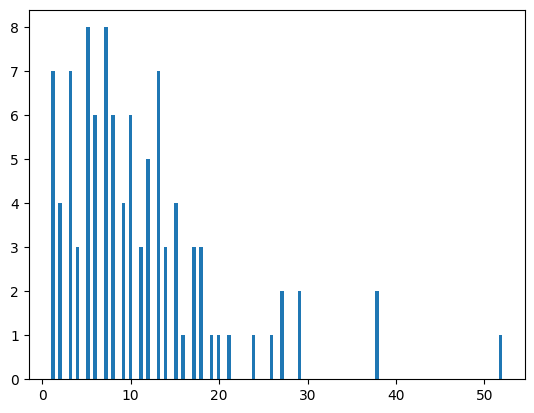

In [20]:
import matplotlib.pyplot as plt
plt.hist(ranks, bins = 128)
plt.show()

In [24]:
def test_vault_scientific(model, device, num_basic=50, nielsen_moves=15):
    model.eval()
    
    # 1. Setup the Secret (Anchor)
    secret_shift = random.randint(-400, 400)
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    
    with torch.no_grad():
        anchor_emb = model.forward_one(anchor_graph)

    vault_graphs = []
    labels = [] # To keep track of what is what
    
    # --- CATEGORY 1: THE TRUE POSITIVE ---
    correct_idx = 0 # We'll keep it at 0 and shuffle later
    true_secret_sub = apply_nielsen_moves_fixed(secret_basis, num_moves=nielsen_moves)
    vault_graphs.append(subgroup_to_graph(true_secret_sub))
    labels.append("SECRET")

    # --- CATEGORY 2: BASIC ALPHABET DECOYS ---
    for _ in range(num_basic):
        r_shift = random.choice([s for s in range(-600, 600) if abs(s - secret_shift) > 150])
        sub = [(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)]
        sub = apply_nielsen_moves_fixed(sub, num_moves=random.randint(1, 10))
        vault_graphs.append(subgroup_to_graph(sub))
        labels.append("ALPHABET")

    # --- CATEGORY 3: SURGICAL DECOYS (1-GEN REPLACED) ---
    for _ in range(32):
        surgical = copy.deepcopy(secret_basis)
        idx_to_corrupt = random.randint(0, 4)
        bad_shift = random.choice([s for s in range(-1000, 1000) if abs(s - secret_shift) > 300])
        surgical[idx_to_corrupt] = (RAAGWord([bad_shift]), RAAGWord([bad_shift + 50]))
        sub = apply_nielsen_moves_fixed(surgical, num_moves=5)
        vault_graphs.append(subgroup_to_graph(sub))
        labels.append("SURGICAL")

    # --- CATEGORY 4: ALGEBRAIC DEPENDENCY (THE COLLAPSE) ---
    for _ in range(32):
        hard_decoy = copy.deepcopy(secret_basis)
        i, j = random.sample(range(4), 2)
        hard_decoy[4] = (hard_decoy[i][0] * hard_decoy[j][0], hard_decoy[i][1] * hard_decoy[j][1])
        sub = apply_nielsen_moves_fixed(hard_decoy, num_moves=15)
        vault_graphs.append(subgroup_to_graph(sub))
        labels.append("ALGEBRAIC")

    # 3. Batch Process Embeddings
    loader = DataLoader(vault_graphs, batch_size=32)
    vault_embs = []
    with torch.no_grad():
        for batch in loader:
            vault_embs.append(model.forward_one(batch.to(device)))
    vault_embs = torch.cat(vault_embs, dim=0)

    # 4. Analysis
    similarities = F.cosine_similarity(anchor_emb, vault_embs).cpu().numpy()
    
    # Map results by category
    results = {"SECRET": [], "ALPHABET": [], "SURGICAL": [], "ALGEBRAIC": []}
    for sim, label in zip(similarities, labels):
        results[label].append(sim)

    predicted_idx = np.argmax(similarities)
    sorted_indices = np.argsort(similarities)[::-1]
    rank = list(sorted_indices).index(0) + 1 # Rank of the actual secret (index 0)
    
    return rank, results

# --- RUN MULTIPLE TRIALS ---
trials = 50
rank_history = []
category_stats = {"ALPHABET": [], "SURGICAL": [], "ALGEBRAIC": [], "SECRET": []}

for t in range(trials):
    rank, trial_results = test_vault_scientific(model, device)
    rank_history.append(rank)
    for k in category_stats:
        category_stats[k].append(np.mean(trial_results[k]))

# --- FINAL REPORT ---
print("\n" + "="*30)
print("📈 CRYPTANALYSIS REPORT")
print("="*30)
print(f"Top-1 Accuracy:  { (np.array(rank_history) == 1).mean() * 100:.2f}%")
print(f"Top-5 Accuracy:  { (np.array(rank_history) <= 5).mean() * 100:.2f}%")
print(f"Mean Rank:       { np.mean(rank_history):.2f} / 115")
print("-" * 30)
print("SIMILARITY PROFILES (The Fingerprint Strength):")
for cat, scores in category_stats.items():
    print(f" > {cat:10}: {np.mean(scores):.4f}")


📈 CRYPTANALYSIS REPORT
Top-1 Accuracy:  6.00%
Top-5 Accuracy:  28.00%
Mean Rank:       19.14 / 115
------------------------------
SIMILARITY PROFILES (The Fingerprint Strength):
 > ALPHABET  : -0.2043
 > SURGICAL  : -0.5009
 > ALGEBRAIC : 0.6266
 > SECRET    : 0.7280
